In [67]:

import gridworlds           # import to trigger registration of the environment
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# create instance
env = gym.make("gridworld-v0")
env.reset()

(array([0, 0]), {})

In [68]:
class Policy:
    def __init__(self,size=5,initial_policy=None,eps_soft=0.4,gamma=0.9):
        self.gamma=gamma
        self.size=size
        self.eps_soft=eps_soft
        if initial_policy ==None:
           self.beh_policy=np.full((self.size**2,4),0.25)
           self.tar_policy=np.full((self.size**2,4),0.25)
     
        else:
            self.beh_policy=initial_policy
            self.tar_policy=np.full((self.size**2,4),0.25)
       
        self.N_detailed=np.zeros((self.size**2,4,self.size**2))
        self.Q=np.zeros((self.size**2,4))
        self.v=np.zeros((self.size**2))
        self.Returns=[[] for i in range(self.size**2)]
        self.Rewards_cum=np.zeros((self.size**2,4))
        self.pos_dict={i*self.size+j: [i,j] for i in range(self.size) for j in range(self.size)}
    def state_translate(self,state):
        return state[0]*self.size+state[1]
    def act_behaviour(self, state):
        return np.random.choice(4, p=self.beh_policy[state])
    
    def act_target(self, state):
        return np.random.choice(4, p=self.target_policy[state])
    
    def eval_episode(self,episode):
        states, actions, rewards= episode 
        next_state=states[-1]
        G=0
        for i, state in reversed(list(enumerate(states[:-1]))):
            action=actions[i]
            reward=rewards[i]
            self.Rewards_cum[state,action]+=reward
            G=self.gamma*G + reward
            self.N_detailed[state,action,next_state]+=1
            if state not in states[:i]:
                self.Returns[state].append(G)
                self.v[state]=sum(self.Returns[state])/len(self.Returns[state])
            next_state=state
    
    def compute_q(self):
        for state in range(self.Q.shape[0]):
            for action in range(self.Q.shape[1]):

                s_a_visits=np.sum(self.N_detailed[state,action])
                if s_a_visits==0:
                    s_a_visits=1 # dirty solution to avoiding nan values
                probs_s_a=self.N_detailed[state,action]/s_a_visits
                s_a_rewards=self.Rewards_cum[state,action]/s_a_visits
                self.Q[state,action]=np.dot(probs_s_a,self.v)+s_a_rewards

    def improve_policy(self):
        self.compute_q()
        for state in range(self.Q.shape[0]):
            best_action_value=np.max(self.Q[state])
            best_actions_am=0
            new_probs_tar=np.zeros(4)
            new_probs_beh=np.zeros(4)
            
            for i, action_value in enumerate(self.Q[state]):
                if action_value== best_action_value:
                    best_actions_am+=1    
            if best_actions_am==4:
                new_probs_tar=np.full(4,0.25)
                new_probs_beh=np.full(4,0.25)

            elif  (1-self.eps_soft)*1/best_actions_am<=(self.eps_soft)*1/(4-best_actions_am):
                new_probs_tar=np.full(4,0.25)
                new_probs_beh=np.full(4,0.25)
            else:
                for i, action_value in enumerate(self.Q[state]):
                    if action_value== best_action_value:
                        new_probs_tar[i]=1/best_actions_am
                        new_probs_beh[i]=(1-self.eps_soft)*1/best_actions_am
                    else:
                        new_probs_beh[i]=(self.eps_soft)*1/(4-best_actions_am)
            self.beh_policy[state]=new_probs_beh
            self.tar_policy[state]=new_probs_tar

        self.Returns=[[] for i in range(self.size**2)]

    def v_mat(self):
        V_mat=np.zeros((self.size,self.size))
        for i, val in enumerate(self.v):
            in_1, in_2=self.pos_dict[i]
            V_mat[in_1,in_2]=val
        return V_mat
    
    def policy_mat(self,pol_id="beh"):
        if pol_id=="beh":
            pi_mat=np.zeros((self.size,self.size,4))
            for i  in range(self.beh_policy.shape[0]):
                in_1, in_2=self.pos_dict[i]
                pi_mat[in_1,in_2]=self.beh_policy[i]
        else:
            pi_mat=np.zeros((self.size,self.size,4))
            for i  in range(self.tar_policy.shape[0]):
                in_1, in_2=self.pos_dict[i]
                pi_mat[in_1,in_2]=self.tar_policy[i]
        return pi_mat
       
    def show_heatmap(self,it_nr):
        fig, ax = plt.subplots()
        V_mat=self.v_mat()
        im = ax.imshow(V_mat, cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(self.size))
        ax.set_yticks(np.arange(self.size))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(self.size):
            for j in range(self.size):
                text = ax.text(j, i, round(V_mat[i, j], 2),
                            ha="center", va="center", color="w")

        ax.set_title(f"State value function heatmap it={it_nr}")
        fig.tight_layout()
        plt.show()
    
    def show_policy(self,it_nr,pol_id="tar"):

        Pi_mat=self.policy_mat(pol_id)
        V_mat=self.v_mat()
        policy_arrows_direction = {0: (0,-1), 1: (1,0), 2:(0,1) , 3:(-1,0) }
       

        

        fig, ax = plt.subplots()
        ax.imshow(V_mat, cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(self.size))
        ax.set_yticks(np.arange(self.size))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(self.size):
            for j in range(self.size):
                best_action_prob = np.max(Pi_mat[i, j])
                for k, action_prob in enumerate(Pi_mat[i, j]):
                    if action_prob==best_action_prob:
                        direction = policy_arrows_direction[k]

                        # Calculate the position for the arrow (center of each cell)
                        x, y = j, i

                        # Add the arrow to the plot
                        arrow_kwargs={'color':"w", "length_includes_head":True,"head_width":0.03}
                        ax.arrow(x, y, direction[0] * 0.2, direction[1] * 0.2,**arrow_kwargs)
        if pol_id=="beh":
            policy_name="behaviour"
        else:
            policy_name="target"
        ax.set_title(f"Gridworld {policy_name} Policy it={it_nr}")
        fig.tight_layout()
        plt.show()
        
    def optimise(self,env,max_iterations, eps_per_iter=100,max_eps_length=50,plot=True):
        for it in range(max_iterations):
            for eps_nr in range(eps_per_iter):
                env.reset()
                state, _ =env.reset()
                episode=[[self.state_translate(state)],[],[]]  

                for i in range(max_eps_length):
                    action = self.act_behaviour(self.state_translate(state))
                    state, reward, terminated, truncated, _ = env.step(action) 
                    episode[0].append(self.state_translate(state))
                    episode[1].append(action)
                    episode[2].append(reward)
                    
                    if terminated or truncated:
                        break
                
                self.eval_episode(episode)
            
            self.improve_policy()
            self.show_heatmap(it)
            self.show_policy(it,"beh")
        self.show_policy(it)   
    
    

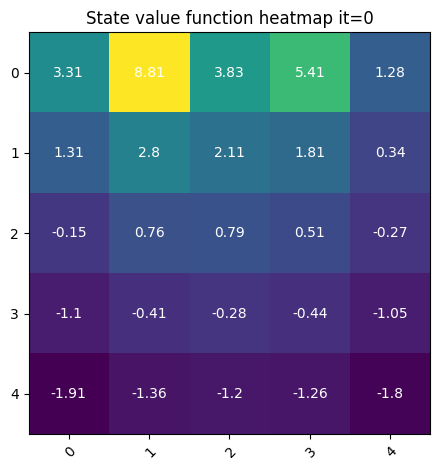

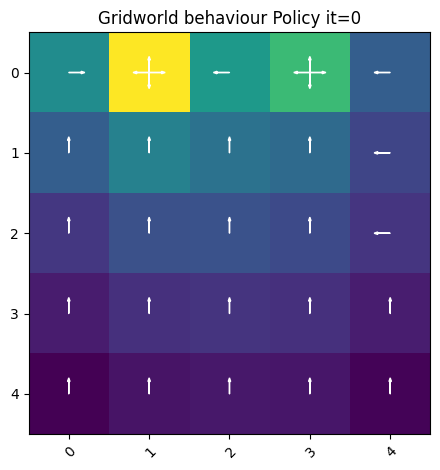

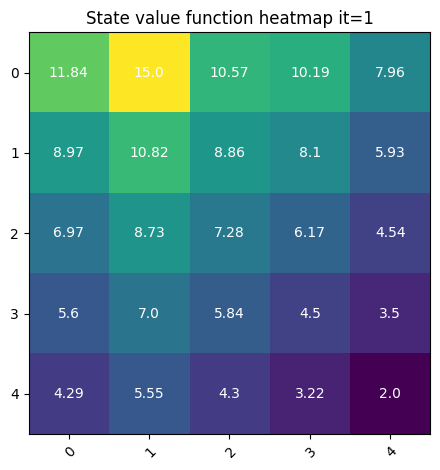

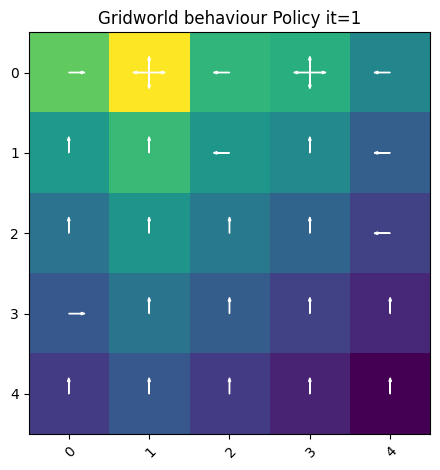

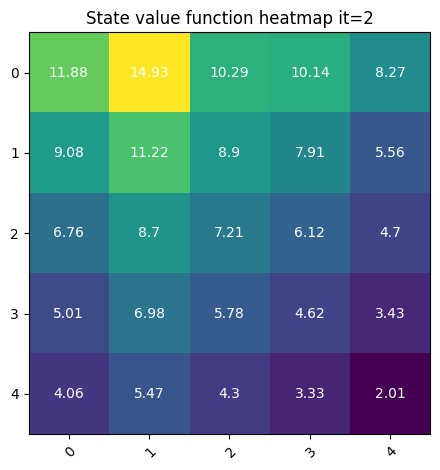

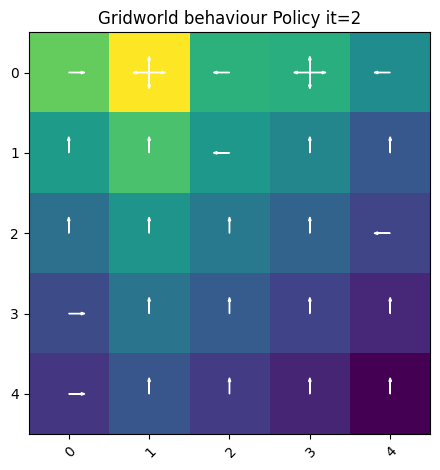

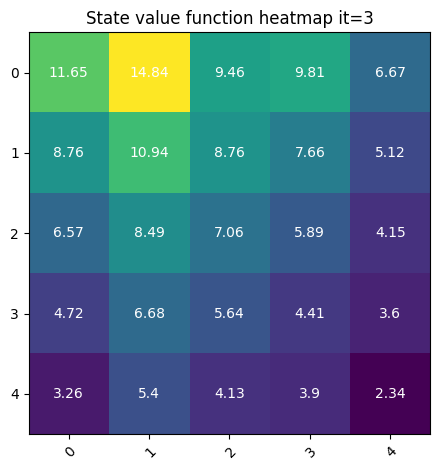

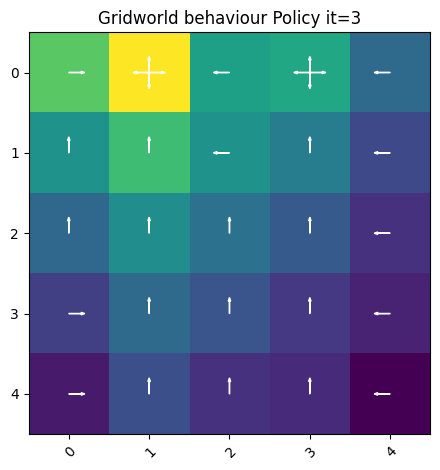

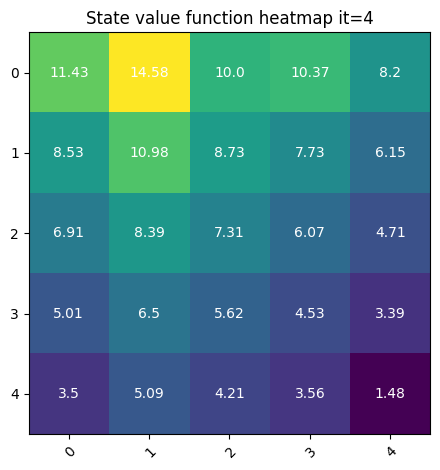

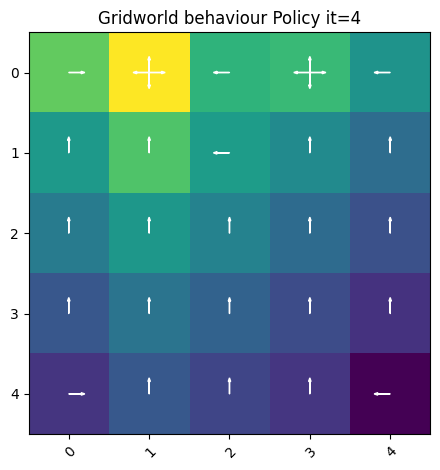

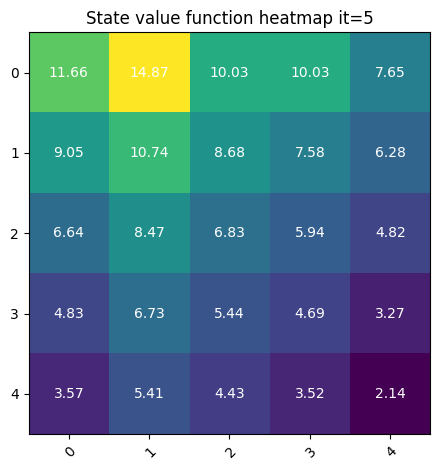

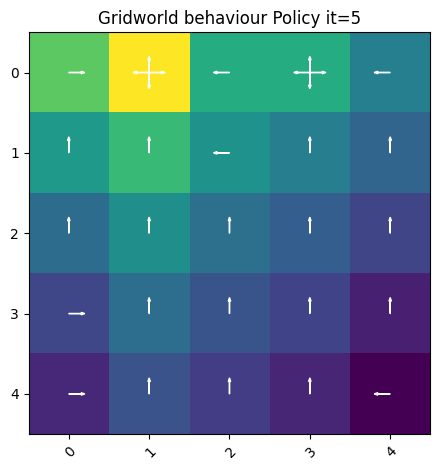

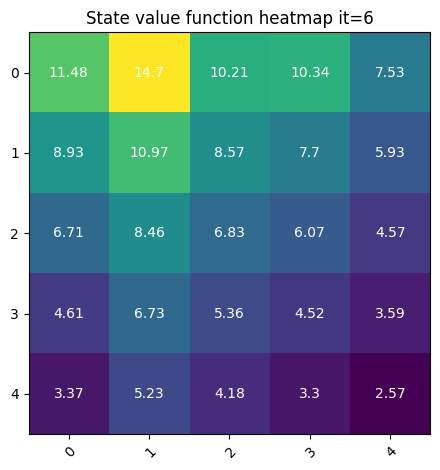

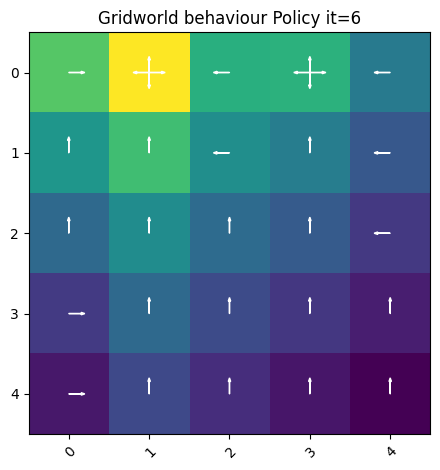

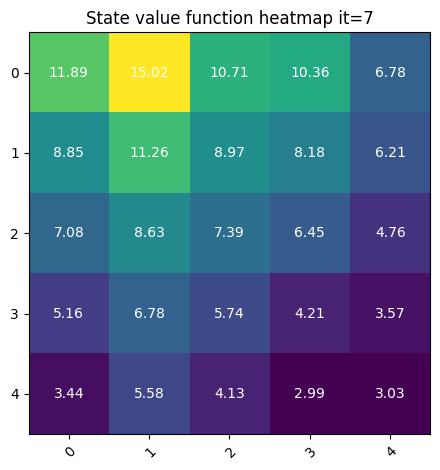

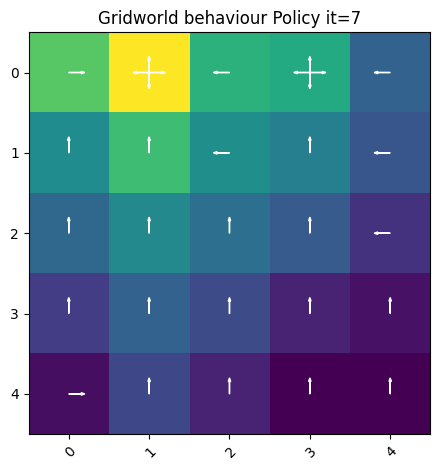

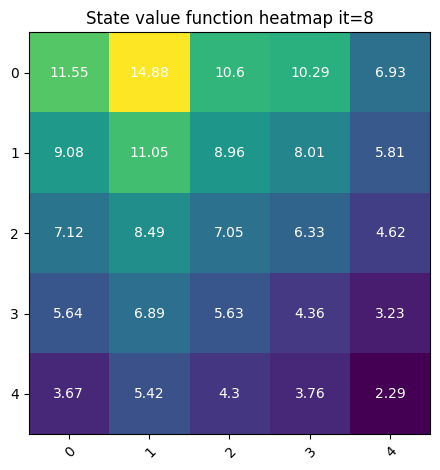

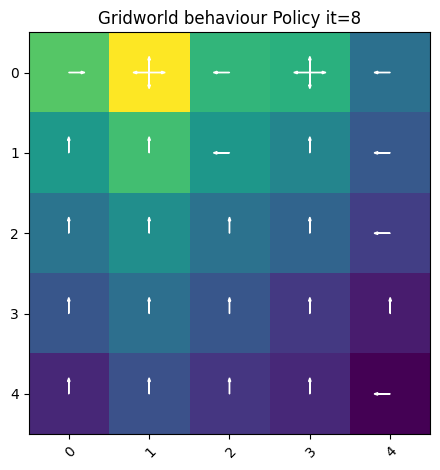

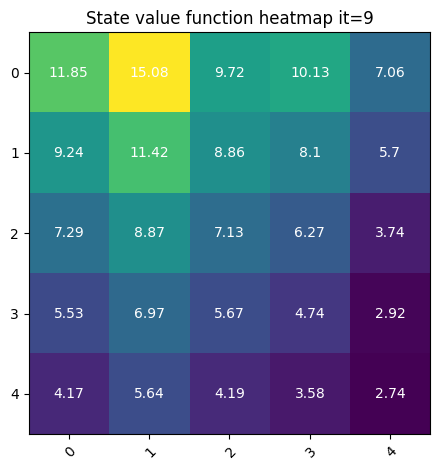

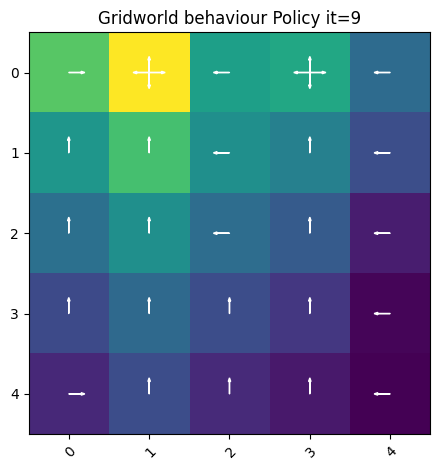

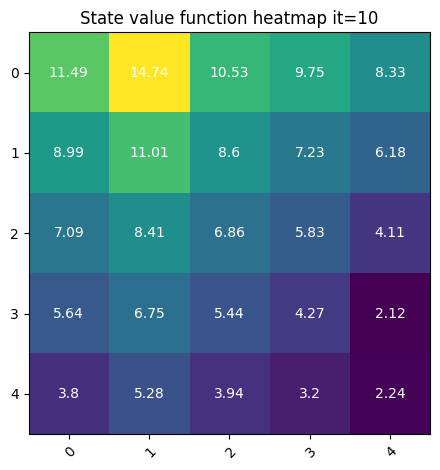

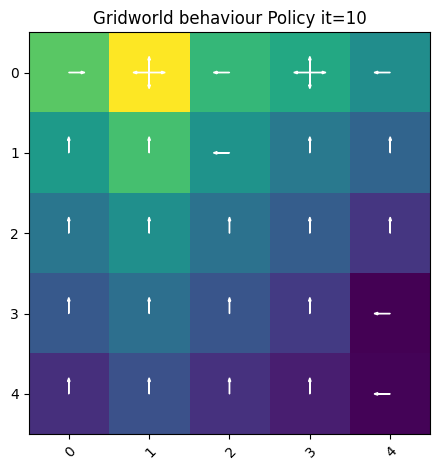

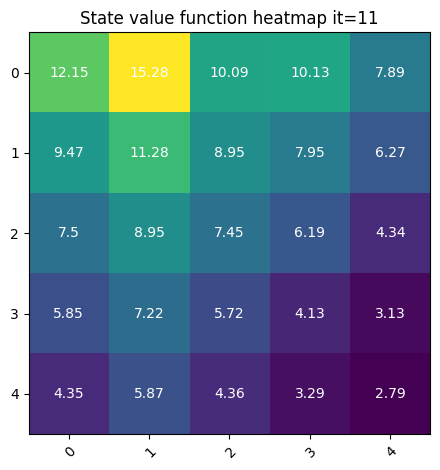

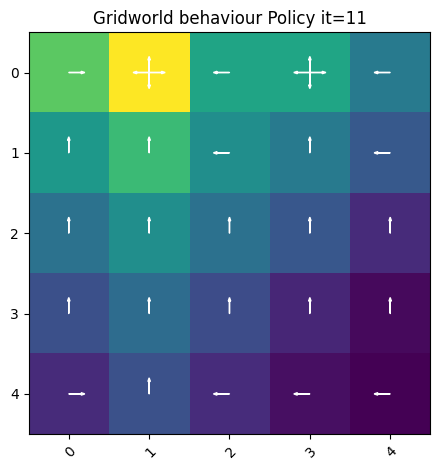

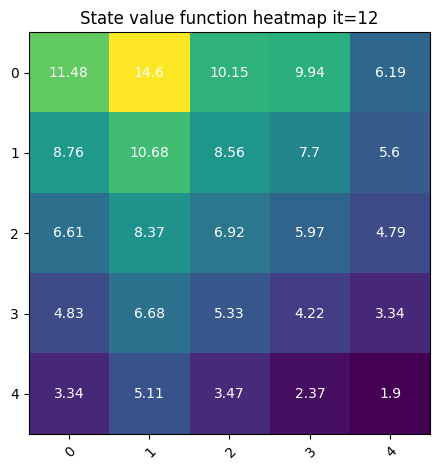

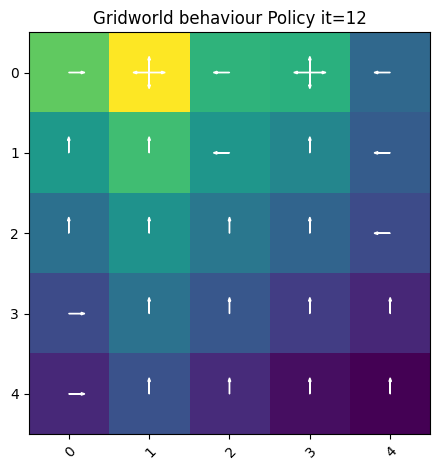

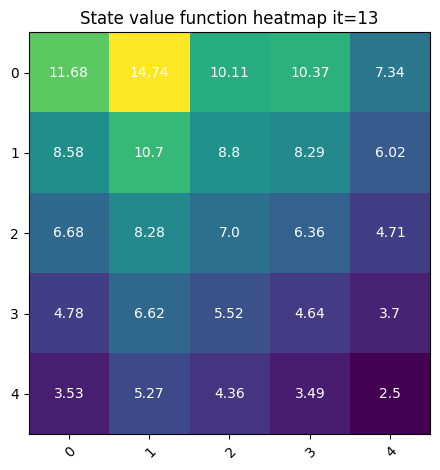

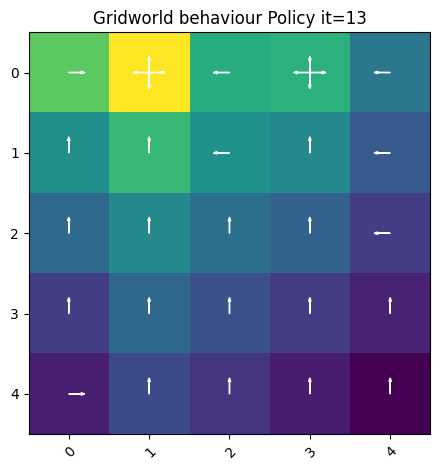

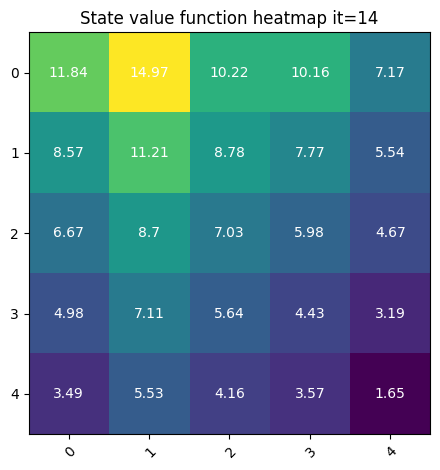

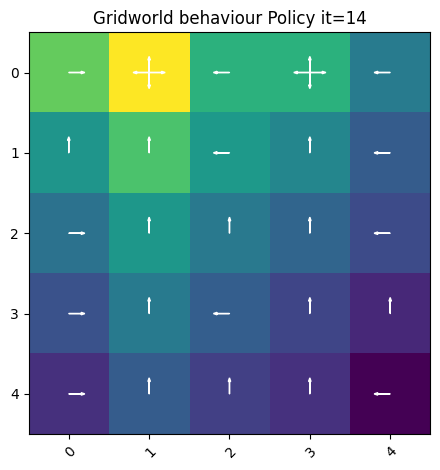

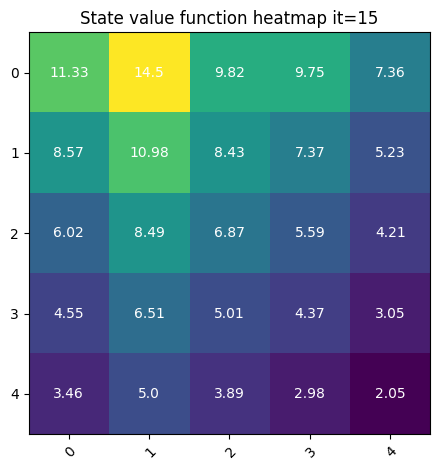

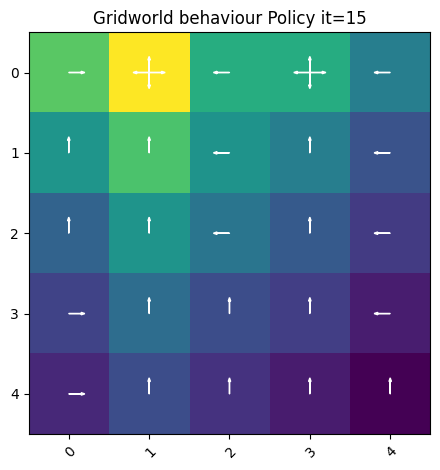

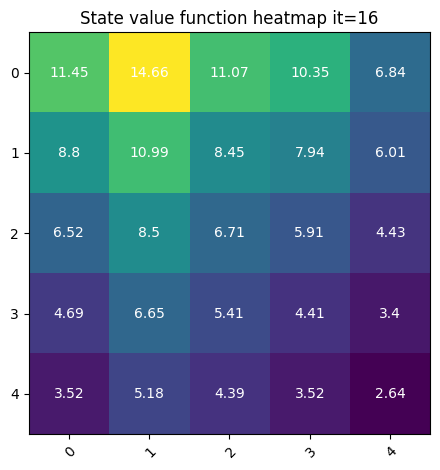

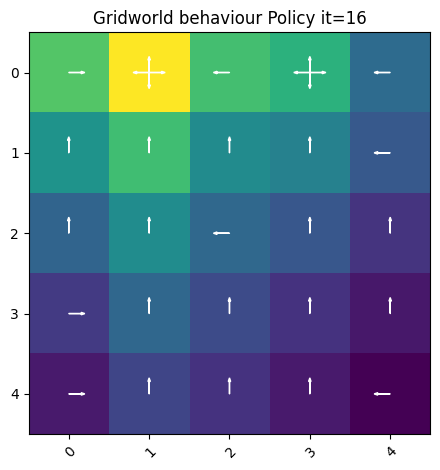

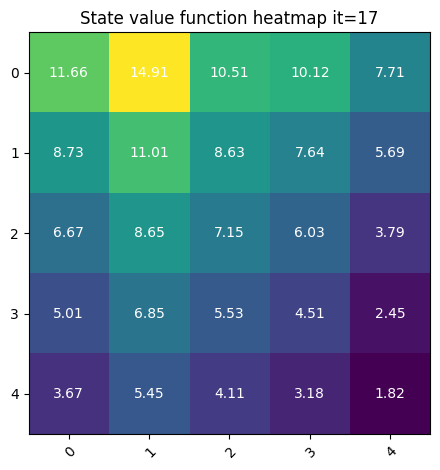

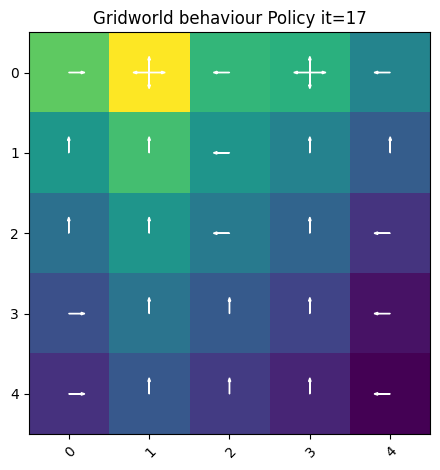

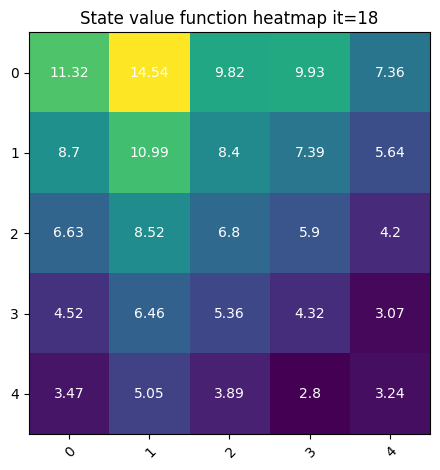

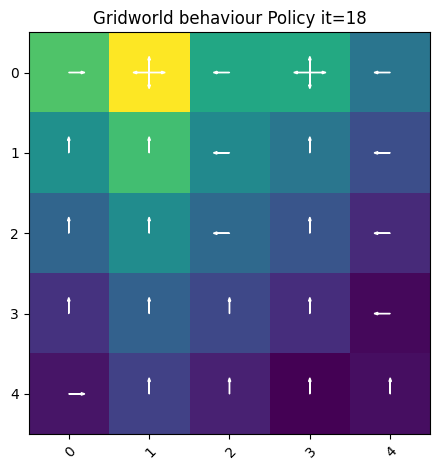

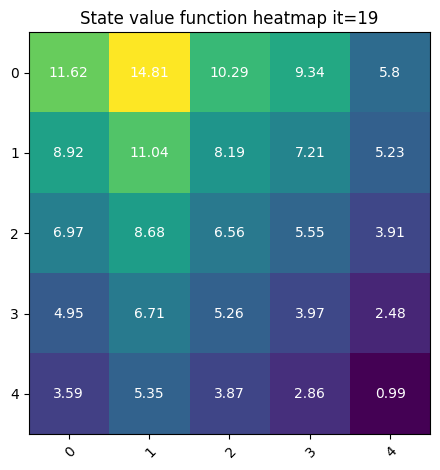

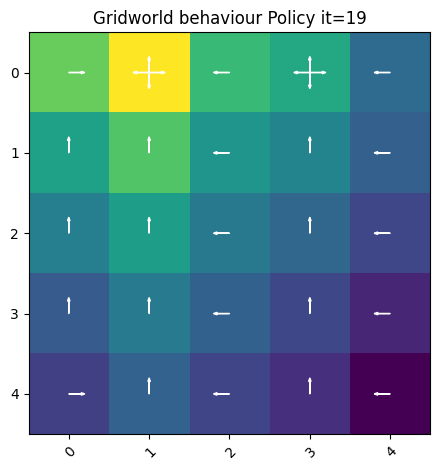

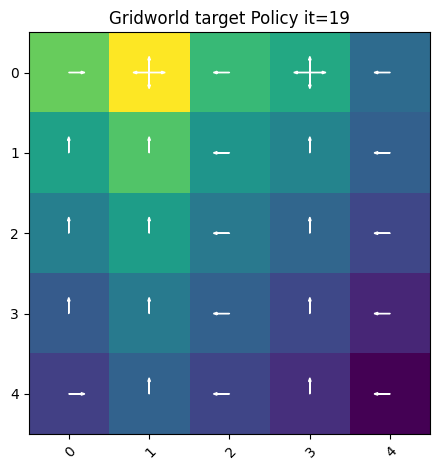

In [69]:
my_policy=Policy()
my_policy.optimise(env,20,eps_per_iter=500)